# 載入相關套件

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
import warnings
warnings.simplefilter('ignore')

# 讀取資料

In [3]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# 觀察 train 資料集

In [4]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


81個欄位，包含 Id 欄位

# 觀察 tset 資料集

In [5]:
##display the first five rows of the train dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


80個欄位，包含 Id 欄位，房價(SalePrice)未知

# 刪除 Id 欄位

In [6]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# 資料預處理

* GrLivArea 與 SalePrice 之間存在異常值
>
> 理論上 GrLivArea (面積範圍) 因與 SalePrice (房價) 成正比


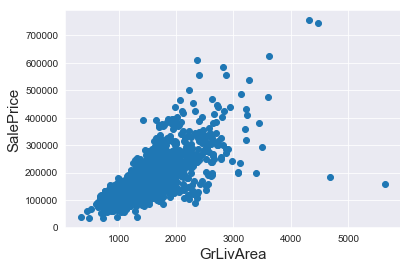

In [7]:
f, ax = plt.subplots()
plt.scatter(x=train['GrLivArea'],y=train['SalePrice'])
plt.xlabel("GrLivArea", fontsize=15)
plt.ylabel("SalePrice", fontsize=15)
plt.show()

* 刪除異常值

In [8]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

# 觀察資料的分布情形


 mu = 180932.92 and sigma = 79467.79



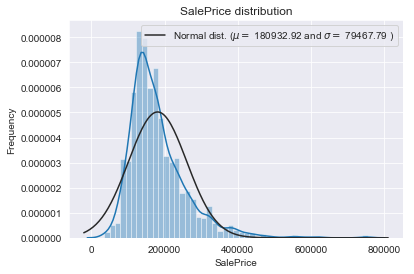

In [9]:
sns.distplot(train['SalePrice'] , fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

plt.show()

* 資料呈現右偏
> 由於該模型的目標值為回歸預測類型，因此將採用回歸模型來進行預測
>
> 在回歸模型中，使用常態分布的資料，才能避免模型在訓練時因資料的 scale 影響到預測結果
>
> 使用 log 對資料的 線性scale 做轉換，讓資料的 scale 呈現非線性，藉此讓資料呈現常態分佈

the mu = 12.02 
 the sigma = 0.40


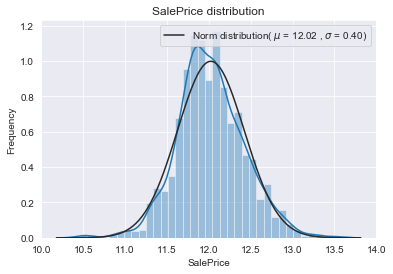

In [10]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm)
(mu,sigma) = norm.fit(train['SalePrice'])
print('the mu = {:.2f} \n the sigma = {:.2f}'.format(mu,sigma))
plt.legend(['Norm distribution( $\mu$ = {:.2f} , $\sigma$ = {:.2f})'.format(mu,sigma)],loc='best')
plt.ylabel('Frequency')
plt.xlabel('SalePrice')
plt.title('SalePrice distribution')

plt.show()

# 特徵工程處理

將 train 資料集與 test 資料集進行合併，一起做特徵工程處理

In [11]:
all_data = pd.concat([train,test],ignore_index=True)
ntrain = train.shape[0]
ntest = test.shape[0]
# 移出目標值 SalePrice
y_train = train.SalePrice.values
# 移除目標值 SalePrice 
all_data.drop('SalePrice',1,inplace=True)
print(all_data.shape)

(2917, 79)


# 尋找遺失值

In [12]:
# 列出每個欄位的資料遺失值比例
all_data_na = (all_data.isnull().sum() / len(all_data)) *100
all_data_na[0:5]

1stFlrSF        0.000
2ndFlrSF        0.000
3SsnPorch       0.000
Alley          93.212
BedroomAbvGr    0.000
dtype: float64

In [13]:
# 移除沒有遺失資料的欄位
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
all_data_na[0:5]

PoolQC        99.691
MiscFeature   96.400
Alley         93.212
Fence         80.425
FireplaceQu   48.680
dtype: float64

In [14]:
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
print(missing_data)

              Missing Ratio
PoolQC               99.691
MiscFeature          96.400
Alley                93.212
Fence                80.425
FireplaceQu          48.680
LotFrontage          16.661
GarageQual            5.451
GarageCond            5.451
GarageFinish          5.451
GarageYrBlt           5.451
GarageType            5.382
BsmtExposure          2.811
BsmtCond              2.811
BsmtQual              2.777
BsmtFinType2          2.743
BsmtFinType1          2.708
MasVnrType            0.823
MasVnrArea            0.788
MSZoning              0.137
BsmtFullBath          0.069
BsmtHalfBath          0.069
Utilities             0.069
Functional            0.069
Electrical            0.034
BsmtUnfSF             0.034
Exterior1st           0.034
Exterior2nd           0.034
TotalBsmtSF           0.034
GarageArea            0.034
GarageCars            0.034
BsmtFinSF2            0.034
BsmtFinSF1            0.034
KitchenQual           0.034
SaleType              0.034


In [15]:
# 列出特定欄位的唯一值
all_data['Utilities'].unique()

array(['AllPub', 'NoSeWa', nan], dtype=object)

In [16]:
# 列出特定欄位的唯一值數量
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

# 繪製個欄位遺失值比例圖

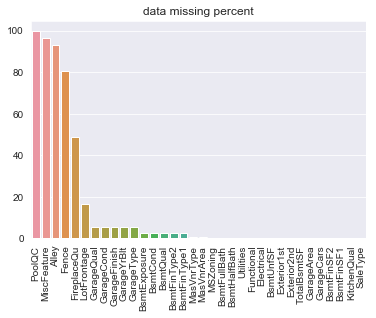

In [17]:
sns.barplot(all_data_na.index,all_data_na.values)
plt.xticks(rotation=90)
plt.title('data missing percent')
plt.show()

# 遺失值處理

PoolQC: 

資料遺失率 => 99.691 %

欄位含意 => 泳池品質

欄位資料類型 => 類別

欄位資料內容 => [ Fx, Fa, Gd, NA ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無泳池相關設施

MiscFeature

資料遺失率 => 96.400 %

欄位含意 => Miscellaneous feature not covered in other categories (雜項功能未在其他類別中涵蓋)

欄位資料類型 => 類別

欄位資料內容 => [ Gar2, NA, Othr, Shed, TenC ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無雜項相關設施

Alley

資料遺失率 => 93.212 %

欄位含意 => 小巷通道的類型

欄位資料類型 => 類別

欄位資料內容 => [ Grvl, Pave, NA ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無小巷通道相關設施

Fence                

資料遺失率 => 80.425 %

欄位含意 => 柵欄品質

欄位資料類型 => 類別

欄位資料內容 => [ GdPrv, MnPrv, GdWo, MnWw, NA ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無柵欄相關設施

FireplaceQu     

資料遺失率 => 48.680 %

欄位含意 => 壁爐品質

欄位資料類型 => 類別

欄位資料內容 => [ Ex, Gd, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無壁爐相關設施

LotFrontage          

資料遺失率 => 16.661 %

欄位含意 => Linear feet of street connected to property (距離街道的距離)

欄位資料類型 => 數字

欄位資料內容 => 21~313

遺失值處理 => 資料內容為數字，需要與其他特徵進行特徵工程處理，產生新的特徵填補遺失值

具有相同里鄰的建築其距離街道的距離也許相似，故將與 Neighborhood 欄位進行特徵工程處理

GarageQual            

資料遺失率 => 5.451 %

欄位含意 => 車庫品質

欄位資料類型 => 類別

欄位資料內容 => [ Ex, Gd, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無車庫相關設施

GarageCond            

資料遺失率 => 5.451 %

欄位含意 => 車庫狀態

欄位資料類型 => 類別

欄位資料內容 => [ Ex, Gd, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無車庫相關設施

GarageFinish

資料遺失率 => 5.451 %

欄位含意 => 車庫裝潢

欄位資料類型 => 類別

欄位資料內容 => [ Ex, Gd, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無車庫相關設施

GarageYrBlt           

資料遺失率 => 5.451 %

欄位含意 => 車庫建立年分

欄位資料類型 => 日期

欄位資料內容 => 1900~2010

遺失值處理 => 以 0 來填補遺失值，表示該建築無車庫相關設施

GarageType            

資料遺失率 => 5.382 %

欄位含意 => 車庫位置

欄位資料類型 => 類型

欄位資料內容 => [ 2Types, Attchd, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無車庫相關設施

BsmtExposure          

資料遺失率 => 2.811 %

欄位含意 => 與花園有關

欄位資料類型 => 類型

欄位資料內容 => [ Gd, Av, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無花園相關設施

BsmtCond              

資料遺失率 => 2.811 %

欄位含意 => 與地下室有關

欄位資料類型 => 類型

欄位資料內容 => [ Gd, Av, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無地下室相關設施

BsmtQual              

資料遺失率 => 2.777 %

欄位含意 => 依據地下室的高度區分等級

欄位資料類型 => 類型

欄位資料內容 => [ Gd, Ta, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無地下室相關設施

BsmtFinType2          

資料遺失率 => 2.743 %

欄位含意 => 依據地下室的面積區分等級

欄位資料類型 => 類型

欄位資料內容 => [ Gd, Ta, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無地下室相關設施

BsmtFinType1          

資料遺失率 => 2.708 %

欄位含意 => 依據地下室的面積區分等級

欄位資料類型 => 類型

欄位資料內容 => [ Gd, Ta, NA, ... ]

遺失值處理 => 資料內容涵蓋 NA ，故遺失值可補 None 處理，表示該建築無地下室相關設施

MasVnrType            

資料遺失率 => 0.823 %

欄位含意 => Masonry veneer type (砌體單板類型)

欄位資料類型 => 類型

欄位資料內容 => [ BrkCmn, BrkFace, None, Na ]

遺失值處理 => 資料內容涵蓋 None、Na ，故遺失值可補 None 處理

MasVnrArea            

資料遺失率 => 0.788 %

欄位含意 => 砌體面積

欄位資料類型 => 數字

欄位資料內容 => 0~160, Na

遺失值處理 => 資料內容涵蓋 Na ，故遺失值可補 0 處理

MSZoning              

資料遺失率 => 0.137 %

欄位含意 => 銷售區分類

欄位資料類型 => 類型

欄位資料內容 => [ A, C, Fv, ...]

遺失值處理 => 資料內容未涵蓋 Na ，故遺失值以最常出現的類型補值 (中位數、眾數)

BsmtFullBath          

資料遺失率 => 0.069 %

欄位含意 => 地下室有無完整的浴室

欄位資料類型 => 數字型類別

欄位資料內容 => [ 0, 1, 2, 3]

遺失值處理 => 資料內容未涵蓋 Na ，故遺失值以 0 補值

Electrical

資料遺失率 => 0.034 %

欄位含意 => 建築電子設備

欄位資料類型 => 類別

欄位資料內容 => [ SBrkr, FuseF, Na]

遺失值處理 => 雖資料內容涵蓋 Na ，但考慮到房屋基本上都有電子設備，故採用中位數補值

* 填補 None

> ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 
'GarageCond', 'GarageFinish', 'GarageType', 'BsmtExposure', 'BsmtCond', 
'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType'] 


In [18]:
var = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageQual', 
'GarageCond', 'GarageFinish', 'GarageType', 'BsmtExposure', 'BsmtCond', 
'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType'] 
all_data[var] = all_data[var].fillna('None')
print('為null的值',max(all_data[var].isnull().sum()))

為null的值 0


* 填補 0

> ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath',
 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtUnfSF',
'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtFinSF2', 'BsmtFinSF1']


In [19]:
var = ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath',
 'BsmtHalfBath', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtUnfSF',
'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtFinSF2', 'BsmtFinSF1']
all_data[var] = all_data[var].fillna(0)
print('為null的值',max(all_data[var].isnull().sum()))

為null的值 0


* 填補 中位數或眾數

> ['MSZoning','Utilities', 'Electrical', 'Exterior1st', 
'Exterior2nd', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']

In [20]:
var = ['MSZoning','Utilities', 'Electrical', 'Exterior1st', 
'Exterior2nd', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'SaleType']
for v in var:
    all_data[v] = all_data[v].fillna(all_data[v].mode()[0])
print('為null的值',max(all_data[var].isnull().sum()))

為null的值 0


* 填補 特徵工程組合後的新特徵

> LotFrontage : groupby(Neighborhood)

In [21]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

* 填補預設值
> Functional 表示房屋功能
>
> 填補 Typ (典型) 作為預設值

In [22]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [23]:
print('檢查是否還有剩餘缺失值:',max(all_data.isnull().sum()))

檢查是否還有剩餘缺失值: 0


# 特徵組合

In [24]:
all_data["TotalHouse"] = all_data["TotalBsmtSF"] + all_data["1stFlrSF"] + all_data["2ndFlrSF"] 
all_data["+_TotalHouse_OverallQual"] = all_data["TotalHouse"] * all_data["OverallQual"]

# 將資料型態為 numerical 但實質含意為 Object 的 Data 轉成 Object

In [25]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# 區分出類別與數字型態的資料

In [26]:
#確定只有 int64, float64, object 三種類型後對欄位名稱執行迴圈, 分別將欄位名稱存於 list 中
numerical_features = []
object_features = []
for dtype, feature in zip(all_data.dtypes, all_data.columns):
    if dtype == 'float64' or dtype == 'int64':
        numerical_features.append(feature)
    else:
        object_features.append(feature)
print(f'{len(numerical_features)} Numerical Features : {numerical_features}\n')
print(f'{len(object_features)} Object Features : {object_features}')

34 Numerical Features : ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath', 'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'OverallQual', 'PoolArea', 'ScreenPorch', 'TotRmsAbvGrd', 'TotalBsmtSF', 'WoodDeckSF', 'YearBuilt', 'YearRemodAdd', 'TotalHouse', '+_TotalHouse_OverallQual']

47 Object Features : ['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1', 'Condition2', 'Electrical', 'ExterCond', 'ExterQual', 'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'Functional', 'GarageCond', 'GarageFinish', 'GarageQual', 'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSSubClass', 'MSZoning', 'MasVnrType'

# 對數字型態的資料做正規化處理

In [27]:
all_data.loc[:, numerical_features] = np.log1p(all_data.loc[:, numerical_features])
all_data[numerical_features].head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,TotalHouse,+_TotalHouse_OverallQual
0,6.753,6.751,0.000,1.386,6.561,0.000,0.693,0.000,5.017,0.000,...,2.079,0.000,0.000,2.197,6.753,0.000,7.603,7.603,7.850,9.796
1,7.141,0.000,0.000,1.386,6.887,0.000,0.000,0.693,5.652,0.000,...,1.946,0.000,0.000,1.946,7.141,5.700,7.589,7.589,7.834,9.625
2,6.825,6.765,0.000,1.386,6.188,0.000,0.693,0.000,6.075,0.000,...,2.079,0.000,0.000,1.946,6.825,0.000,7.602,7.602,7.904,9.849
3,6.869,6.629,0.000,1.386,5.380,0.000,0.693,0.000,6.293,5.609,...,2.079,0.000,0.000,2.079,6.629,0.000,7.558,7.586,7.814,9.759
4,7.044,6.960,0.000,1.609,6.486,0.000,0.693,0.000,6.196,0.000,...,2.197,0.000,0.000,2.303,7.044,5.263,7.601,7.601,8.115,10.194


# 對類別型態的特徵做編碼處理

* 將有大小順序及無大小順序的類別分成兩類

# 無大小順序的類別

* 獨熱編碼處理

In [28]:
one_hot_features = ['Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
                    'Electrical', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Functional', 'GarageFinish',
                    'GarageType', 'Heating', 'HouseStyle', 'LandContour', 'LandSlope', 'LotConfig', 'LotShape',
                    'MSSubClass', 'MSZoning', 'MasVnrType', 'MiscFeature', 'Neighborhood', 'PavedDrive', 'RoofMatl',
                    'RoofStyle', 'SaleCondition', 'SaleType', 'Street', 'Utilities']

In [29]:
df_one_hot = pd.get_dummies(all_data[one_hot_features])

In [30]:
all_data = pd.merge(all_data, df_one_hot,left_index=True,right_index=True)

In [31]:
all_data = all_data.drop(columns = one_hot_features)

In [32]:
all_data.head(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,6.753,6.751,0.000,1.386,TA,No,6.561,0.000,GLQ,Unf,...,0,0,0,0,0,1,0,1,1,0
1,7.141,0.000,0.000,1.386,TA,Gd,6.887,0.000,ALQ,Unf,...,0,0,0,0,0,1,0,1,1,0
2,6.825,6.765,0.000,1.386,TA,Mn,6.188,0.000,GLQ,Unf,...,0,0,0,0,0,1,0,1,1,0
3,6.869,6.629,0.000,1.386,Gd,No,5.380,0.000,ALQ,Unf,...,0,0,0,0,0,1,0,1,1,0
4,7.044,6.960,0.000,1.609,TA,Av,6.486,0.000,GLQ,Unf,...,0,0,0,0,0,1,0,1,1,0


# 有大小順序的類別

* 當目標值是數字時，LabelEncoder()會依據數字大小給予相對的大小順序

In [33]:
lb_make = LabelEncoder()
all_data['MoSold'] = lb_make.fit_transform(all_data['MoSold'].values)

In [34]:
lb_make = LabelEncoder()
all_data['YrSold'] = lb_make.fit_transform(all_data['YrSold'].values)

* 當目標值是字串時，LabelEncoder()會依據字串長度給予相對的大小順序，但這並符合實際情形，因此需要自定義

In [35]:
mapper = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
all_data['BsmtCond']=all_data['BsmtCond'].map(mapper)

In [36]:
mapper = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
all_data['BsmtExposure']=all_data['BsmtExposure'].map(mapper)

In [37]:
mapper = {'GLQ': 5, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
all_data['BsmtFinType1']=all_data['BsmtFinType1'].map(mapper)

In [38]:
mapper = {'GLQ': 5, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
all_data['BsmtFinType2']=all_data['BsmtFinType2'].map(mapper)

In [39]:
mapper = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
all_data['BsmtQual']=all_data['BsmtQual'].map(mapper)

In [40]:
mapper = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
all_data['ExterCond']=all_data['ExterCond'].map(mapper)

In [41]:
mapper = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
all_data['ExterQual']=all_data['ExterQual'].map(mapper)

In [42]:
mapper = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'None': 0}
all_data['Fence']=all_data['Fence'].map(mapper)

In [43]:
mapper = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
all_data['FireplaceQu']=all_data['FireplaceQu'].map(mapper)

In [44]:
mapper = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
all_data['GarageCond']=all_data['GarageCond'].map(mapper)

In [45]:
mapper = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
all_data['GarageQual']=all_data['GarageQual'].map(mapper)

In [46]:
mapper = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
all_data['HeatingQC']=all_data['HeatingQC'].map(mapper)

In [47]:
mapper = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0}
all_data['KitchenQual']=all_data['KitchenQual'].map(mapper)

In [48]:
mapper = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
all_data['PoolQC']=all_data['PoolQC'].map(mapper)

# 將原先合併起來一起做特徵工程處理的 train set 與 test set 拆解還原

In [49]:
print('all_data.shape = ',all_data.shape)

all_data.shape =  (2917, 258)


In [50]:
print('y_train.shape = ',y_train.shape)

y_train.shape =  (1458,)


In [51]:
print('ntrain count = ',ntrain)

ntrain count =  1458


In [52]:
print('ntest count = ',ntest)

ntest count =  1459


In [53]:
# all_data.shape = 2917
# 1458 + 1459 = 2917
print('ntest + ntrain = ', ntrain+ntest)

ntest + ntrain =  2917


In [54]:
train_data = all_data[0:ntrain]
test_data = all_data[ntrain:]
print('train_data.shape = ',train_data.shape)
print('test_data.shape = ', test_data.shape)

train_data.shape =  (1458, 258)
test_data.shape =  (1459, 258)


# 建立模型

In [55]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

## 透過交叉驗證計算損失函數，可有效避免 Overfitting 問題

In [56]:
# 交叉驗證
n_folds = 5
def rmsle_cv(model, train, y_train):
    # kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    # rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error',cv=kf))
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring='neg_mean_squared_error',cv=n_folds))
    return rmse

## 透過交叉驗證進行 grid_search ，可有效避免 Overfitting 問題

In [57]:
def grid_search(estimator, param_grid, X, y):
    ## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
    grid_search = GridSearchCV(estimator = estimator, param_grid = param_grid, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
    grid_result = grid_search.fit(X, y)
    print("Best Accuracy: %f using %s" % (np.sqrt((-1)*grid_result.best_score_), grid_result.best_params_))
    return grid_result.best_params_

* lasso

In [58]:
lasso = Lasso()
score = rmsle_cv(lasso, train_data, y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.3995 (0.0158)



In [59]:
lasso = Lasso()

# 設定要訓練的超參數組合
alpha = [0.0003, 0.0004, 0.0005]
max_iter = [2000, 5000, 10000]
param_grid = dict(alpha=alpha, max_iter=max_iter)

best_params = grid_search(lasso, param_grid, train_data, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Accuracy: 0.117133 using {'alpha': 0.0004, 'max_iter': 2000}


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    2.2s finished


In [60]:
# 使用最佳參數重新建立模型
lasso = Lasso(alpha = best_params['alpha'], 
              max_iter = best_params['max_iter'])
score = rmsle_cv(lasso, train_data, y_train)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1158 (0.0060)



* ElasticNet()

In [61]:
ENet = ElasticNet()
score = rmsle_cv(ENet, train_data, y_train)
print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ENet score: 0.3995 (0.0158)



In [62]:
ENet = ElasticNet()

# 設定要訓練的超參數組合
alpha = [0.0003, 0.0004, 0.0005]
l1_ratio = [0.5, 0.7, 0.9]
param_grid = dict(alpha= alpha, l1_ratio= l1_ratio)

best_params = grid_search(ENet, param_grid, train_data, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  27 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    0.9s finished


Best Accuracy: 0.117151 using {'alpha': 0.0005, 'l1_ratio': 0.9}


In [63]:
# 使用最佳參數重新建立模型
ENet = ElasticNet(alpha = best_params['alpha'], 
              l1_ratio = best_params['l1_ratio'])
score = rmsle_cv(ENet, train_data, y_train)
print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ENet score: 0.1158 (0.0060)



* KernelRidge()

In [64]:
kRR = KernelRidge()
score = rmsle_cv(kRR, train_data, y_train)
print("\nkRR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


kRR score: 0.1219 (0.0066)



In [65]:
kRR = KernelRidge()

# 設定要訓練的超參數組合
alpha = [0.1, 0.2, 0.3]
kernel = ['polynomial']
degree = [2, 3, 4]
coef0 = [0.4, 0.6, 0.8]

param_grid = dict(alpha= alpha, kernel= kernel, degree= degree, coef0= coef0)

best_params = grid_search(kRR, param_grid, train_data, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  74 out of  81 | elapsed:    3.1s remaining:    0.2s


Best Accuracy: 0.120688 using {'alpha': 0.2, 'coef0': 0.8, 'degree': 2, 'kernel': 'polynomial'}


[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:    3.4s finished


In [66]:
# 使用最佳參數重新建立模型
kRR = KernelRidge(alpha = best_params['alpha'], kernel = best_params['kernel'], 
                  degree = best_params['degree'], coef0 = best_params['coef0'])
score = rmsle_cv(kRR, train_data, y_train)
print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ENet score: 0.1202 (0.0077)



* GradientBoostingRegressor()

In [67]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost, train_data, y_train)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


GBoost score: 0.1161 (0.0072)



* XGBRegressor

In [68]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsle_cv(model_xgb, train_data, y_train)
print("\nmodel_xgb: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


model_xgb: 0.1154 (0.0063)



# 整合學習 - StackingCVRegressor

* 透過 CV 交叉驗證的方式，可有效減少 Overfitting 問題， 預設值為 5 。

In [69]:
from mlxtend.regressor import StackingCVRegressor

In [70]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [71]:
stacking_clf = StackingCVRegressor(regressors=[ENet, kRR, GBoost, model_xgb],
                                   meta_regressor=lasso, 
                                   use_features_in_secondary=True)

In [72]:
score = rmsle_cv(stacking_clf, train_data, y_train)
print("\nstacking_clf score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


stacking_clf score: 0.1101 (0.0062)



In [73]:
stacking_clf.fit(train_data.values, y_train)

StackingCVRegressor(cv=5,
          meta_regressor=Lasso(alpha=0.0004, copy_X=True, fit_intercept=True, max_iter=2000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
          refit=True,
          regressors=[ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False), KernelRidge(alpha=0.2, coef0=0.8, degree=2, gamma=None, kernel='poly...=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5213)],
          shuffle=True, store_train_meta_features=False,
          use_features_in_secondary=True)

In [74]:
print('Stacking Score:',stacking_clf.score(train_data.values, y_train))

Stacking Score: 0.9682448765422658


In [75]:
stacked_pred = np.expm1(stacking_clf.predict(test_data.values))

In [76]:
result=pd.DataFrame({'Id':test_ID, 'SalePrice':stacked_pred})
result.to_csv("submission_StackingCVRegressor.csv",index=False)